In [120]:
!wget -nc -q https://raw.githubusercontent.com/jpatokal/openflights/master/data/airports.dat
!wget -nc -q https://raw.githubusercontent.com/jpatokal/openflights/master/data/routes.dat

In [121]:
import networkx as nx
import math
from PIL import Image, ImageDraw
import pyproj
import numpy as np
import matplotlib.pyplot as plt
import geopy.distance
import pandas as pd

In [122]:
G = nx.DiGraph()

In [123]:
airportsDF = pd.read_csv('airports.dat', header=None, names=['id', 'name', 'city', 'country', 'IATA', 'ICAO', 'lat', 'lon', 'alt', 'timezone', 'DST', 'Tz', 'type', 'source'])

for index, row in airportsDF.iterrows():
    if row['IATA'] == '\\N':
        print(row['IATA'])
        continue
    G.add_node(row['IATA'], pos=(row['lat'],row['lon']))

\N
\N
\N
\N
\N
\N
\N
\N
\N
\N
\N
\N
\N
\N
\N
\N
\N
\N
\N
\N
\N
\N
\N
\N
\N
\N
\N
\N
\N
\N
\N
\N
\N
\N
\N
\N
\N
\N
\N
\N
\N
\N
\N
\N
\N
\N
\N
\N
\N
\N
\N
\N
\N
\N
\N
\N
\N
\N
\N
\N
\N
\N
\N
\N
\N
\N
\N
\N
\N
\N
\N
\N
\N
\N
\N
\N
\N
\N
\N
\N
\N
\N
\N
\N
\N
\N
\N
\N
\N
\N
\N
\N
\N
\N
\N
\N
\N
\N
\N
\N
\N
\N
\N
\N
\N
\N
\N
\N
\N
\N
\N
\N
\N
\N
\N
\N
\N
\N
\N
\N
\N
\N
\N
\N
\N
\N
\N
\N
\N
\N
\N
\N
\N
\N
\N
\N
\N
\N
\N
\N
\N
\N
\N
\N
\N
\N
\N
\N
\N
\N
\N
\N
\N
\N
\N
\N
\N
\N
\N
\N
\N
\N
\N
\N
\N
\N
\N
\N
\N
\N
\N
\N
\N
\N
\N
\N
\N
\N
\N
\N
\N
\N
\N
\N
\N
\N
\N
\N
\N
\N
\N
\N
\N
\N
\N
\N
\N
\N
\N
\N
\N
\N
\N
\N
\N
\N
\N
\N
\N
\N
\N
\N
\N
\N
\N
\N
\N
\N
\N
\N
\N
\N
\N
\N
\N
\N
\N
\N
\N
\N
\N
\N
\N
\N
\N
\N
\N
\N
\N
\N
\N
\N
\N
\N
\N
\N
\N
\N
\N
\N
\N
\N
\N
\N
\N
\N
\N
\N
\N
\N
\N
\N
\N
\N
\N
\N
\N
\N
\N
\N
\N
\N
\N
\N
\N
\N
\N
\N
\N
\N
\N
\N
\N
\N
\N
\N
\N
\N
\N
\N
\N
\N
\N
\N
\N
\N
\N
\N
\N
\N
\N
\N
\N
\N
\N
\N
\N
\N
\N
\N
\N
\N
\N
\N
\N
\N
\N
\N
\N
\N
\N
\N
\N
\N
\N
\N
\N
\N
\N
\N
\N
\N
\N
\

In [124]:
print(len(G.nodes))
print(len(G.edges))

6072
0


In [125]:
print(G.nodes['TRF'])
#print(G.nodes['AOS'])

{'pos': (59.1866989136, 10.258600235)}


In [126]:
routesDF = pd.read_csv('routes.dat', header=None, names=['airline', 'airlineID', 'source', 'sourceID', 'dest', 'destID', 'codeshare', 'stops', 'equipment'])

for index, row in routesDF.iterrows():
    if(row['source'] not in G.nodes or row['dest'] not in G.nodes):
        continue
    dist = geopy.distance.distance((G.nodes[row['source']]['pos']), (G.nodes[row['dest']]['pos'])).km
    G.add_edge(row['source'], row['dest'], weight=dist)

In [139]:
# remove nodes with zero degree
G.remove_nodes_from(list(nx.isolates(G)))

In [140]:
print(len(G.nodes))
print(len(G.edges))

3257
37042


In [129]:
H = G.copy()
for node in H.nodes(data=True) :
  print(node[1])
  if node[1] == {}:
    G.remove_node(node[0])

{'pos': (-6.081689834590001, 145.391998291)}
{'pos': (-5.20707988739, 145.789001465)}
{'pos': (-5.826789855957031, 144.29600524902344)}
{'pos': (-6.569803, 146.725977)}
{'pos': (-9.44338035583496, 147.22000122070312)}
{'pos': (-3.58383011818, 143.669006348)}
{'pos': (61.1604995728, -45.4259986877)}
{'pos': (64.19090271, -51.6781005859)}
{'pos': (67.0122218992, -50.7116031647)}
{'pos': (76.5311965942, -68.7032012939)}
{'pos': (65.66000366210938, -18.07270050048828)}
{'pos': (65.2833023071289, -14.401399612426758)}
{'pos': (64.295601, -15.2272)}
{'pos': (65.952301, -17.426001)}
{'pos': (66.05809783935547, -23.135299682617188)}
{'pos': (63.985000610352, -22.605600357056)}
{'pos': (65.555801, -23.965)}
{'pos': (64.1299972534, -21.9405994415)}
{'pos': (66.133301, -18.9167)}
{'pos': (63.42430114746094, -20.27890014648437)}
{'pos': (46.48500061035156, -84.5093994140625)}
{'pos': (51.3918991089, -56.083099365200006)}
{'pos': (49.079833, -125.775583)}
{'pos': (68.534401, -89.808098)}
{'pos': (4

In [141]:
print(len(G.nodes))
print(len(G.edges))

3257
37042


In [131]:
G.is_directed()

True

In [132]:
nodes = sorted(G.degree, key=lambda x: x[1])
print(nodes)
print(G.degree)

[('HFN', 0), ('HZK', 0), ('PFJ', 0), ('SIJ', 0), ('VEY', 0), ('YAZ', 0), ('YBB', 0), ('YCH', 0), ('YCT', 0), ('YCW', 0), ('YDA', 0), ('YDB', 0), ('YDL', 0), ('YDN', 0), ('YEN', 0), ('YET', 0), ('YEU', 0), ('YFE', 0), ('YFR', 0), ('YGQ', 0), ('YHB', 0), ('YIB', 0), ('YJN', 0), ('YKY', 0), ('YKZ', 0), ('YLD', 0), ('YLJ', 0), ('YLT', 0), ('YMA', 0), ('YMJ', 0), ('YMW', 0), ('YMX', 0), ('YND', 0), ('YNM', 0), ('YOC', 0), ('YOD', 0), ('YPA', 0), ('YPE', 0), ('YPG', 0), ('YPQ', 0), ('YQA', 0), ('YQH', 0), ('YQV', 0), ('YQW', 0), ('YRI', 0), ('YRJ', 0), ('YRM', 0), ('YSC', 0), ('YSR', 0), ('YSU', 0), ('YTR', 0), ('YVC', 0), ('YVG', 0), ('YVT', 0), ('YVV', 0), ('YWA', 0), ('YWY', 0), ('YXD', 0), ('YXR', 0), ('YYL', 0), ('YYN', 0), ('YYW', 0), ('YZD', 0), ('YZE', 0), ('YZH', 0), ('YZU', 0), ('YZW', 0), ('YZX', 0), ('ZFA', 0), ('QLD', 0), ('BUJ', 0), ('VVZ', 0), ('GJL', 0), ('TIN', 0), ('TAF', 0), ('BFW', 0), ('LOO', 0), ('TMX', 0), ('BYK', 0), ('DJO', 0), ('HGO', 0), ('MJC', 0), ('SPY', 0), ('A

In [133]:
for node in nodes :
  if node[1] == 0:
    G.remove_node(node[0])

In [134]:
nodes = sorted(G.degree, key=lambda x: x[1])
print(nodes)

[('FMI', 1), ('TTA', 1), ('KZI', 1), ('VDA', 1), ('TUA', 1), ('LUR', 1), ('TLJ', 1), ('PTU', 1), ('MSW', 1), ('UII', 1), ('LJA', 1), ('JQE', 1), ('IUE', 1), ('PTJ', 1), ('DLZ', 1), ('IGG', 1), ('PTH', 1), ('CHU', 1), ('KUK', 1), ('AGN', 1), ('ELV', 1), ('KPV', 1), ('PIP', 1), ('KYK', 1), ('SLQ', 1), ('MLY', 1), ('CMP', 1), ('BVS', 1), ('STZ', 1), ('SXX', 1), ('QFG', 1), ('THU', 2), ('AEY', 2), ('EGS', 2), ('IFJ', 2), ('YBR', 2), ('YFS', 2), ('YGK', 2), ('YJT', 2), ('YLL', 2), ('YPL', 2), ('YPR', 2), ('YQL', 2), ('YUB', 2), ('YVM', 2), ('YXH', 2), ('YYF', 2), ('YZP', 2), ('YZR', 2), ('YZT', 2), ('ZFM', 2), ('MZW', 2), ('TEE', 2), ('CFK', 2), ('TGR', 2), ('TML', 2), ('NYI', 2), ('TKD', 2), ('IBA', 2), ('ILR', 2), ('JOS', 2), ('KAD', 2), ('SKO', 2), ('YOL', 2), ('ANR', 2), ('OST', 2), ('MHG', 2), ('XFW', 2), ('AGB', 2), ('URE', 2), ('TAY', 2), ('IVL', 2), ('JOE', 2), ('KAJ', 2), ('KAO', 2), ('KTT', 2), ('KUO', 2), ('RVN', 2), ('SVL', 2), ('GLO', 2), ('ILY', 2), ('DND', 2), ('TRE', 2), ('M

In [135]:
print(len(G.nodes))
print(len(G.edges))

3257
37042


In [148]:
print(G.degree("LIS"))
print(G.degree("ZYL"))
print(G.degree("AAE"))

204
5
14


In [144]:
# Graph density
nx.density(G)

0.0034929492252181843

In [145]:
# Graph diameter
nx.diameter(G)

NetworkXError: Found infinite path length because the digraph is not strongly connected

477


(array([2.209e+03, 3.710e+02, 1.420e+02, 1.130e+02, 5.600e+01, 5.000e+01,
        4.300e+01, 4.800e+01, 1.900e+01, 3.000e+01, 1.700e+01, 1.900e+01,
        1.300e+01, 1.000e+01, 1.000e+01, 1.400e+01, 9.000e+00, 1.100e+01,
        6.000e+00, 5.000e+00, 8.000e+00, 5.000e+00, 1.000e+00, 5.000e+00,
        4.000e+00, 2.000e+00, 5.000e+00, 2.000e+00, 6.000e+00, 3.000e+00,
        3.000e+00, 2.000e+00, 3.000e+00, 2.000e+00, 0.000e+00, 0.000e+00,
        2.000e+00, 2.000e+00, 0.000e+00, 0.000e+00, 2.000e+00, 0.000e+00,
        1.000e+00, 0.000e+00, 1.000e+00, 1.000e+00, 2.000e+00]),
 array([  1.        ,  11.12765957,  21.25531915,  31.38297872,
         41.5106383 ,  51.63829787,  61.76595745,  71.89361702,
         82.0212766 ,  92.14893617, 102.27659574, 112.40425532,
        122.53191489, 132.65957447, 142.78723404, 152.91489362,
        163.04255319, 173.17021277, 183.29787234, 193.42553191,
        203.55319149, 213.68085106, 223.80851064, 233.93617021,
        244.06382979, 254.1914893

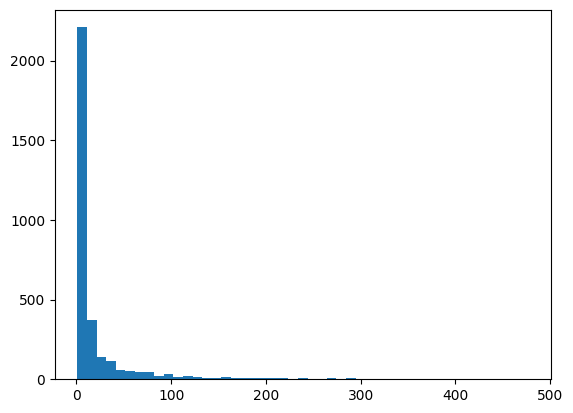

In [146]:
# Degree Distribution
degrees = [G.degree(n) for n in G.nodes()]
print(max(degrees))
plt.hist(degrees, bins=int(max(degrees)/10))
# for i in range(0, max(degrees)):
#   print(i, degrees.count(i))

In [147]:
# compute graph degree centrality
dc = nx.degree_centrality(G)
print(max(dc))
print(min(dc))
# compute eigen vector centrality
ec = nx.eigenvector_centrality(G)
print(max(ec))
print(min(ec))
# compute closeness centrality
cc = nx.closeness_centrality(G)
print(max(cc))
print(min(cc))
# compute betweenness centrality
bc = nx.betweenness_centrality(G)
print(max(bc))
print(min(bc))
# compute pagerank
pr = nx.pagerank(G)
print(max(pr))
print(min(pr))
# compute clustering coefficient
cl = nx.clustering(G)
print(cl)

ZYL
AAE
ZYL
AAE
ZYL
AAE
ZYL
AAE
ZYL
AAE
{'GKA': 1.0, 'MAG': 0.5714285714285714, 'HGU': 0.390625, 'LAE': 0.3888888888888889, 'POM': 0.11553030303030302, 'WWK': 0.8333333333333334, 'UAK': 0.3, 'GOH': 0.17857142857142858, 'SFJ': 0.2857142857142857, 'THU': 0, 'AEY': 0, 'EGS': 0, 'IFJ': 0, 'KEF': 0.4926644581164221, 'RKV': 0, 'YAM': 0.75, 'YAY': 0.6666666666666666, 'YBC': 0.9166666666666666, 'YBG': 0.74, 'YBK': 0.5555555555555556, 'YBL': 1.0, 'YBR': 0, 'YCB': 0.6666666666666666, 'YCD': 1.0, 'YCG': 1.0, 'YCL': 0, 'YCO': 0.3333333333333333, 'YCY': 0, 'YZS': 0.3333333333333333, 'YDF': 0.65625, 'YDQ': 0, 'YEG': 0.3239590942293645, 'YEK': 0.6666666666666666, 'YEV': 0.09523809523809523, 'YFB': 0.022222222222222223, 'YFC': 1.0, 'YFO': 1.0, 'YFS': 0, 'YGK': 0, 'YGL': 0.3333333333333333, 'YGP': 1.0, 'YGR': 0.5, 'YHD': 0.3333333333333333, 'YHI': 0.3333333333333333, 'YHK': 1.0, 'YHM': 0.5, 'YHU': 0.4166666666666667, 'YHY': 1.0, 'YHZ': 0.2802441731409545, 'YIO': 0, 'YJT': 1.0, 'YKA': 1.0, 'YKF': 1.0, '

In [149]:
# generate strongly connected components
scc = nx.strongly_connected_components(G)
largest = max(scc, key=len)
print(len(largest))
#for node in largest:
  #print(G.nodes[node].get('country'))

3190


In [ ]:
# average shortest path
avg_path_length = nx.average_shortest_path_length(G)
print(avg_path_length)


In [ ]:
G.nodes['LIS']

In [ ]:
# Draw the graph in a map
# latitude = float(G.nodes['LIS'].get('pos')[0])
# longitude = float(G.nodes['LIS'].get('pos')[1])

# #resolution of image you are using
# mapWidth = 2048;
# mapHeight = 1025;

# #get x value
# x = (mapWidth*(180+longitude)/360)%mapWidth+(mapWidth/2);
# #convert from degrees to radians
# latRad = latitude*math.pi/180;
# #get y value
# mercN = math.log(math.tan((math.pi/4)+(latRad/2)));
# y = (mapHeight/2)-(mapWidth*mercN/(2*math.pi));
# print(x, y)

# Define the source and destination projections
source_projection = pyproj.Proj(init='epsg:4326')  # WGS 84 (standard lat/lon)
destination_projection = pyproj.Proj(init='epsg:3857')  # Web Mercator

# Input geographic coordinates (longitude, latitude)
lon, lat = float(G.nodes['LIS'].get('pos')[0]), float(G.nodes['LIS'].get('pos')[1])  # Example coordinates for New York City

# Project the coordinates to the destination projection
x, y = pyproj.transform(source_projection, destination_projection, lon, lat)
print(x, y)

def project_to_pixel(x, y, scale, x_offset, y_offset):
    pixel_x = (x - x_offset) * scale
    pixel_y = (y - y_offset) * scale
    return pixel_x, pixel_y

# Calculate the pixel coordinates
scale = 0.00001 # Adjust as needed
x_offset, y_offset = 0, 0  # Adjust as needed
x, y = project_to_pixel(x, y, scale, x_offset, y_offset)
print(x, y)
image = Image.open("openflights-apdb-2048.png")
draw = ImageDraw.Draw(image)
draw.ellipse((x,y, x+50, y+50), fill="black")
image.show()